T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format.

### 参考资料
https://zhuanlan.zhihu.com/p/455216504

In [1]:
print(1)

1


In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

f:\anaconda\envs\clm2\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
f:\anaconda\envs\clm2\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
f:\anaconda\envs\clm2\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


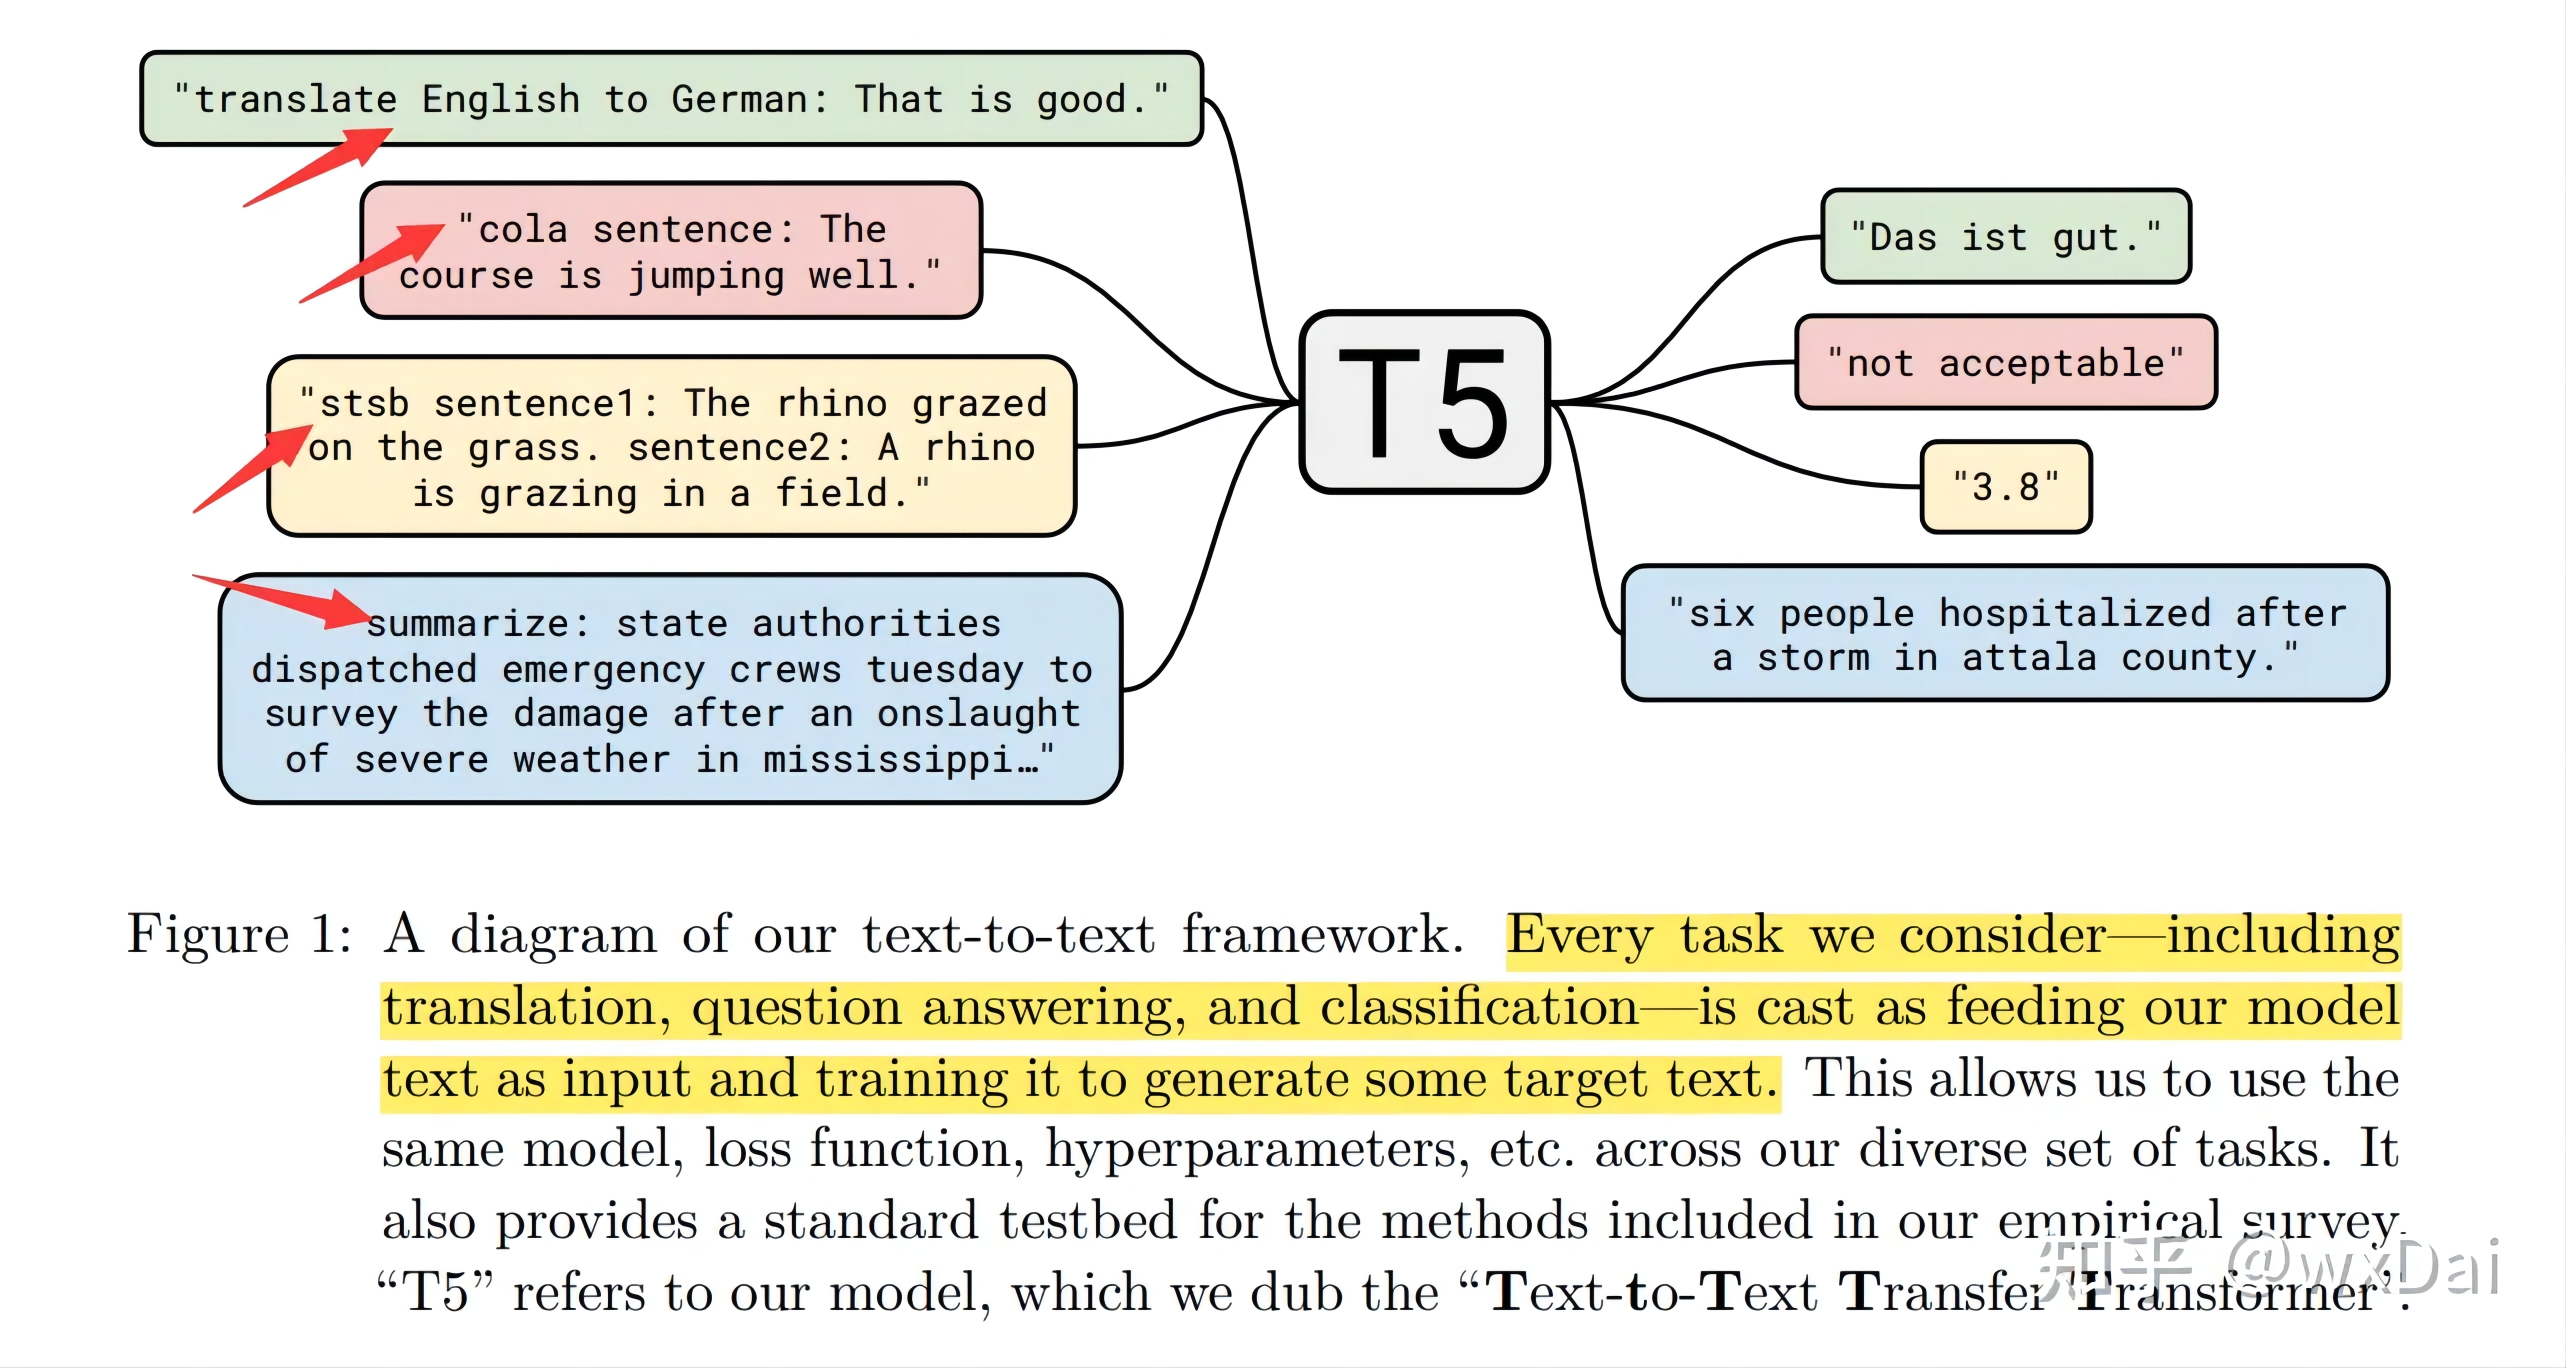

In [3]:
from IPython import display
display.Image('./images/t5_1.jpg')

T5 通过为每个任务对应的输入添加不同的前缀，可以很好地直接应用在各种任务上(开盒即食)，例如(图中左上角红色箭头标出):
翻译 task 前缀: translate English to German: <s1>
摘要 task 前缀: summarize: <s1>
cola (语法可接受性分类 task): cola sentence: <s1>
stsb (语义相似度 task): stsb sentence1: <s1> sentence2: <s2>

## 有监督训练

T5 是通过 teacher forcing 来训练的。这意味着在训练时，我们需要一个输入序列和一个相应的目标序列。使用 input_ids 作为输入序列提供给 Encoder 输入端。目标序列前缀 SOS (T5中使用<pad>, id=0) 得到 decoder_input_ids 提供给 Decoder 输入端，目标序列后缀 EOS (T5中使用</s>, id=1) 得到 Decoder 输出端的 labels。以上面的英翻德为例:

    input_ids: 'translate English to German: That is good. </s>'
    decoder_input_ids: '<pad> Das ist gut.'
    labels: 'Das ist gut. </s>'

In [4]:
tokenizer = T5Tokenizer.from_pretrained("../../bert/T5-base")
model = T5ForConditionalGeneration.from_pretrained("../../bert/T5-base")

In [5]:
input_ids = tokenizer('translate English to German: That is good.', return_tensors='pt').input_ids
labels = tokenizer('Das ist gut.', return_tensors='pt').input_ids
loss = model(input_ids=input_ids, labels=labels).loss

In [6]:
tokenizer('translate English to German: That is good.', return_tensors='pt')

{'input_ids': tensor([[13959,  1566,    12,  2968,    10,   466,    19,   207,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [7]:
input_ids

tensor([[13959,  1566,    12,  2968,    10,   466,    19,   207,     5,     1]])

In [8]:
labels

tensor([[ 644,  229, 1806,    5,    1]])

注意：这里 input_ids 只取了 encode 后的 input_ids 而未取 attention_mask, 因为这里只是单句，T5 内部会自动构造一个全 1 的 mask 矩阵，1 代表不 mask, 注意 labels 和 input_ids 都被 tokenizer 后缀了 </s> 的id=1，decoder_input_ids 在 T5 内部会根据 labels 右移得到，所以这里不需要额外传入。

为了计算 loss，T5 模型只需要 2 个输入: Input_ids (编码后的输入序列的 Input_ids) 和 labels (编码后的目标序列的 Input_ids)。还要注意任务前缀: 在编码之前，我们在输入序列前添加如 ' translate English to German: ' 等任务前缀。这将有助于提高性能，因为这个任务前缀是在 T5 训练时使用的。

## 无监督学习

输入序列被哨兵 tokens (论文里称 sentinel tokens) 随机 masked, 输出序列由相同的哨兵 tokens 和真实的掩码 tokens 串联而成。哨兵是 T5Tokenizer 词表中长度为 100 的特殊 tokens: <extra_id_0>,<extra_id_1>, … <extra_id_99>. 分别对应 id 为 32099，32098，... ，32000。

例如，"the cute dog walks in the park" 这句当 mask "cute dog" 和 "the" 时应该进行如下处理:

In [9]:
input_ids = tokenizer('The <extra_id_0> walks in <extra_id_1> park', return_tensors='pt').input_ids
input_ids2 = tokenizer('The <extra_id_1> walks in <extra_id_1> park', return_tensors='pt').input_ids
labels = tokenizer('<extra_id_0> cute dog <extra_id_1> the <extra_id_2>', return_tensors='pt').input_ids
# the forward function automatically creates the correct decoder_input_ids
loss = model(input_ids=input_ids, labels=labels).loss

In [10]:
input_ids

tensor([[   37, 32099, 10681,    16, 32098,  2447,     1]])

In [11]:
input_ids2

tensor([[   37, 32098, 10681,    16, 32098,  2447,     1]])

In [12]:
labels

tensor([[32099,  5295,  1782, 32098,     8, 32097,     1]])

In [13]:
loss

tensor(3.5416, grad_fn=<NllLossBackward>)

# 3 Forward 函数剖析

transformers 库中关于 T5 有三类模型：T5EncoderModel、T5Model、T5ForConditionalGeneration。官方文档中相关描述为

    T5EncoderModel：The bare T5 Model transformer outputting encoder's raw hidden-states without any specific head on top.
    T5Model: The bare T5 Model transformer outputting raw hidden-states without any specific head on top.
    T5ForConditionalGeneration: T5 Model with a language modeling head on top.

T5EncoderModel = Encoder
T5Model = T5EncoderModel + Decoder
T5ForConditionalGeneration = T5Model + lmhead (nn.Linear(d_model, vocab_size))

这里我们采用 T5ForConditionalGeneration。T5 有 5 种不同的 size (t5-small、t5-base、t5-large、t5-3b、t5-11b)，这里我们选择 t5-base。

## 英翻德任务

In [14]:
import torch

__Step1：__ 函数 from_pretrained() 得到 tokenizer 和 model，model_name_path 值为模型文件夹路径。

In [15]:
model_name_or_path = '../../bert/T5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name_or_path)
model = T5ForConditionalGeneration.from_pretrained(model_name_or_path)

__Step2：__ 假设我们有两个 training examples，并定义任务前缀以及句子最大长度。这里我们将 max_source_length、max_target_length 分别设置为 512、128，这两个超参数是根据任务来定的，这里只是为了提供一种规范写法。

In [16]:
input_sequence_1 = "Welcome to NYC"
output_sequence_1 = "Bienvenue à NYC"

input_sequence_2 = "HuggingFace is a company"
output_sequence_2 = "HuggingFace est une entreprise"

task_prefix = "translate English to French: "
max_source_length = 512
max_target_length = 128

Step3：编码 inputs 和 outputs: padding 为 'longest' 指输入句子长度 pad 到此 batch 中句子的最大长度， truncation 为 True 代表将长度大于 max_length 的句子裁剪到 max_length，return_tensors='pt' 指返回 torch.Tensor (记得加任务前缀)。

In [17]:
input_sequences = [input_sequence_1, input_sequence_2]
encoding = tokenizer([task_prefix + sequence for sequence in input_sequences],
                     padding='longest',
                     max_length=max_source_length,
                     truncation=True,
                     return_tensors="pt")
input_ids, attention_mask = encoding.input_ids, encoding.attention_mask

# encode the targets
target_encoding = tokenizer([output_sequence_1, output_sequence_2],
                            padding='longest',
                            max_length=max_target_length,
                            truncation=True,
                            return_tensors='pt')
decoder_attention_mask = target_encoding.attention_mask
labels = target_encoding.input_ids

In [18]:
input_ids

tensor([[13959,  1566,    12,  2379,    10,  5242,    12, 13465,     1,     0,
             0,     0,     0,     0],
        [13959,  1566,    12,  2379,    10, 11560,  3896,   371,  3302,    19,
             3,     9,   349,     1]])

In [19]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [20]:
labels

tensor([[10520, 15098,     3,    85, 13465,     1,     0,     0],
        [11560,  3896,   371,  3302,   259,   245, 11089,     1]])

In [21]:
decoder_attention_mask

tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])

Step4：对无效 labels 进行 mask，置成 -100 这是因为最后 CrossEntropyLoss 的 ignore_index 为 -100，我们在后面会看到。

In [22]:
labels[labels == tokenizer.pad_token_id] = -100

In [23]:
labels

tensor([[10520, 15098,     3,    85, 13465,     1,  -100,  -100],
        [11560,  3896,   371,  3302,   259,   245, 11089,     1]])

Step5：进入 forward 函数

In [24]:
outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_attention_mask=decoder_attention_mask , labels=labels)

In [25]:
outputs.loss

tensor(0.2055, grad_fn=<NllLossBackward>)

In [26]:
outputs.logits.size()

torch.Size([2, 8, 32128])

In [27]:
outputs[0]

tensor(0.2055, grad_fn=<NllLossBackward>)

# 用T5做 summarize

In [28]:
text = "" \
       "Mr Putin says that his country is threatened. " \
       "It is not. NATO is a defensive alliance. " \
       "Even after Crimea, it has held back from putting permanent combat forces into eastern Europe. " \
       "The real threat is Mr Putin. " \
       "When he issues his demands down the barrel of a gun, " \
       "it should stiffen the resolve both of the West and of the resilient Ukrainians to deter and resist him." \
       ""

input_ids = tokenizer('summarize: ' + text, return_tensors='pt').input_ids

In [29]:
model.generate(input_ids)[0]

tensor([    0,     3,   122,   322,    23,     9,     3, 23685,    49,    10,
            3,    99,     3,    88,   807,   112,  7328,   323,     8, 10650])

In [30]:
# <pad> 0   </s>1
tokenizer('<pad> </s>', return_tensors='pt')

f:\anaconda\envs\clm2\lib\site-packages\transformers\models\t5\tokenization_t5.py:191: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


{'input_ids': tensor([[0, 1]]), 'attention_mask': tensor([[1, 1]])}

默认生成采用参数 greedy_search、max_length=20，skip_special_tokens=True 代表 decode 时将特殊字符去掉，这里即句头的 <pad>。若模型遇到 EOS 即 </s> 而结束时还将去掉 </s>。

In [31]:
tokenizer.decode(model.generate(input_ids,max_length=110)[0], skip_special_tokens=True)

'gloria borger: if he issues his demands down the barrel of a gun, it should stiffen resolve. borger: he should deter and resist the west and of the resilient Ukrainians. borger: if he issues his demands down the barrel of a gun, it should stiffen resolve.'

In [32]:
tokenizer.decode(model.generate(input_ids,max_length=110, no_repeat_ngram_size=1)[0], skip_special_tokens=True)

"gloria: Mr Putin says his country is threatened, but it's not. NATO hasn’t put permanent combat forces into eastern Europe yet; real threat lies with him in Ukraine and the West alike? she writes that when putin issues demands down barrel of gun should deter west from resisting move to stop invasion by Russia or other powers like Iran-Ukraine alliance for peace talks on border security as well Asean countries do so too!"

In [59]:
text = "sized fill-in-the-blank:It is a cat.<mask>"
input_ids = tokenizer('summarize: ' + text, return_tensors='pt').input_ids
model.generate(input_ids)[0]
tokenizer('<pad></s>', return_tensors='pt')
tokenizer.decode(model.generate(input_ids,max_length=110)[0], skip_special_tokens=True)

'sized fill-in-the-blank:It is a cat.mask>'

In [56]:

ARTICLE_TO_SUMMARIZE = "summarize: My friends are cool but they eat too many carbs."
inputs = tokenizer([ARTICLE_TO_SUMMARIZE], return_tensors="pt")

# Generate Summary
summary_ids = model.generate(inputs["input_ids"])
print(tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False))

a friend of mine eats too many carbs .


# 用T5做填空

In [70]:
# 输入文本，注意加mask
text = 'A wonderful movie.<extra_id_0>'

encoded = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
input_ids = encoded['input_ids']
tokenizer('<pad></s>', return_tensors='pt')

# 就正常用
outputs = model.generate(input_ids=input_ids,
                          num_beams=200, num_return_sequences=20,
                          max_length=5)

_0_index = text.index('<extra_id_0>')
_result_prefix = text[:_0_index]
_result_suffix = text[_0_index+12:]  # 尾部内容

def _filter(output, end_token='<extra_id_1>'):
    # <pad>  <extra_id_0>
    # 第一个是<pad> (index at 0) ,然后是 <extra_id_0> (32099),然后是后面的东西
    _txt = tokenizer.decode(output[2:], skip_special_tokens=False, clean_up_tokenization_spaces=False)
    # 如果有尾部的话，decode最后还会呼出一个<extra_id_1>作为结尾，这时候得把这个去掉
    if end_token in _txt:
        _end_token_index = _txt.index(end_token)
        return _result_prefix + _txt[:_end_token_index] + _result_suffix
    else:
        return _result_prefix + _txt + _result_suffix
results = list(map(_filter, outputs))
results

['A wonderful movie.</s> <pad> <pad>',
 'A wonderful movie.Thank you.',
 'A wonderful movie.Thank you!',
 'A wonderful movie..</s> <pad>',
 'A wonderful movie.Thanks.</s>',
 'A wonderful movie.Thanks!</s>',
 'A wonderful movie.I love it',
 'A wonderful movie.Enjoy!</s>',
 'A wonderful movie.Love it!',
 'A wonderful movie.Love it.',
 'A wonderful movie.Highly recommended.',
 'A wonderful movie.Great movie.',
 'A wonderful movie.Enjoy.</s>',
 'A wonderful movie..</s>',
 'A wonderful movie.Thanks for sharing',
 'A wonderful movie.I loved it',
 'A wonderful movie.Hope you enjoy',
 'A wonderful movie.Good movie.',
 'A wonderful movie.Well done.',
 'A wonderful movie.Bravo.</s>']

In [ ]:
text2 = 'A wonderful movie.<extra_id_0>'